In [1]:
import os
import json
import librosa
import numpy as np
import pandas as pd

# Paths to JSON and audio files
json_folder = 'JSON'
audio_folder = 'cleaned_wav_files'

# Match audio and JSON files
json_files = {os.path.splitext(f)[0]: os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')}
audio_files = {os.path.splitext(f)[0]: os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith(('.wav', '.m4a', '.mp3'))}

matched_files = {name: (json_files[name], audio_files[name]) for name in json_files if name in audio_files}


{'cricket toppic': ('JSON/cricket toppic.json', 'cleaned_wav_files/cricket toppic.wav'), 'R1': ('JSON/R1.json', 'cleaned_wav_files/R1.wav'), 'New Recording 6': ('JSON/New Recording 6.json', 'cleaned_wav_files/New Recording 6.wav'), 'Mirpur Road': ('JSON/Mirpur Road.json', 'cleaned_wav_files/Mirpur Road.wav'), 'Recording_1': ('JSON/Recording_1.json', 'cleaned_wav_files/Recording_1.wav'), 'Oct 7, 9.34 AM': ('JSON/Oct 7, 9.34 AM.json', 'cleaned_wav_files/Oct 7, 9.34 AM.wav'), 'keralas calture': ('JSON/keralas calture.json', 'cleaned_wav_files/keralas calture.wav'), 'the scientist': ('JSON/the scientist.json', 'cleaned_wav_files/the scientist.wav'), 'Recording_2': ('JSON/Recording_2.json', 'cleaned_wav_files/Recording_2.wav'), 'R5': ('JSON/R5.json', 'cleaned_wav_files/R5.wav'), 'Sep 23, 9.24 AM': ('JSON/Sep 23, 9.24 AM.json', 'cleaned_wav_files/Sep 23, 9.24 AM.wav'), 'English 1st conversation': ('JSON/English 1st conversation.json', 'cleaned_wav_files/English 1st conversation.wav'), 'SS pr

In [2]:
import os
import json
import librosa
import numpy as np
import pandas as pd

# Paths to JSON and audio files
json_folder = 'JSON'
audio_folder = 'cleaned_wav_files'

# Match audio and JSON files
json_files = {os.path.splitext(f)[0]: os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')}
audio_files = {os.path.splitext(f)[0]: os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith(('.wav', '.m4a', '.mp3'))}

matched_files = {name: (json_files[name], audio_files[name]) for name in json_files if name in audio_files}

def load_annotations(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    annotations = []
    for item in data[0]['annotations'][0]['result']:
        if item['type'] == 'labels':
            start = item['value']['start']
            end = item['value']['end']
            label = item['value']['labels'][0]
            annotations.append((start, end, label))
    return annotations

def extract_audio_segments(audio_file, annotations, sr=16000):
    y, _ = librosa.load(audio_file, sr=sr)
    segments = []
    for start, end, label in annotations:
        segment = y[int(start * sr):int(end * sr)]
        segments.append((segment, label))
    return segments

dataset = []
files_loaded = []

for name, (json_path, audio_path) in matched_files.items():
    if len(load_annotations(json_path)) != 0:
        files_loaded.append(json_path)
        annotations = load_annotations(json_path)
        print(annotations)
        audio_segments = extract_audio_segments(audio_path, annotations)
        dataset.extend(audio_segments)

def extract_features(segments, n_mfcc=40, max_length=300):
    features, labels = [], []
    for i, (segment, label) in enumerate(segments):
        try:
            # Dynamically adjust n_fft based on signal length
            n_fft = min(2048, len(segment))  # Use the smaller of 2048 or segment length

            # Extract MFCC features with adjusted n_fft
            mfcc = librosa.feature.mfcc(y=segment, sr=16000, n_mfcc=n_mfcc, n_fft=n_fft)

            # Handle variable lengths (pad if short, truncate if long)
            if mfcc.shape[1] < max_length:
                padded_mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
            else:
                padded_mfcc = mfcc[:, :max_length]

            # Append features and labels
            features.append(padded_mfcc.T)
            labels.append(0 if label == 'Field pause' else 1)

        except Exception as e:
            print(f"Error processing segment {i}: {e}")

    return np.array(features), np.array(labels)

X, y = extract_features(dataset)

[(0.008701943712084824, 7.1442957876216395, 'Field pause'), (7.155227142462438, 8.68177631726604, 'Non Field pause'), (8.649081301551037, 9.070198315289963, 'Non Field pause'), (9.057038408610623, 11.42342902986303, 'Non Field pause'), (11.416517369217345, 17.724011900230565, 'Non Field pause'), (18.692322285848245, 19.85624292104333, 'Non Field pause'), (17.71848919157698, 18.695246709554766, 'Field pause'), (19.849911152005557, 25.05051131010084, 'Non Field pause'), (25.047092299687172, 26.36893181503435, 'Non Field pause'), (26.365413324686916, 29.12022045622905, 'Non Field pause'), (29.1168963845681, 43.599129983207746, 'Non Field pause'), (45.93904488665863, 47.886711075201156, 'Non Field pause'), (43.58488380290978, 45.93612046295211, 'Non Field pause'), (47.88243971402007, 58.99476239484616, 'Non Field pause'), (58.98816871575477, 61.13469571634068, 'Non Field pause'), (61.120642541494206, 61.77571345175475, 'Non Field pause'), (61.768300094049486, 62.37073137759267, 'Non Field 

/Users/rittique/Python_Projects/Filled_Pause_detection/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:370: RuntimeWarning: divide by zero encountered in scalar floor_divide
  util.MAX_MEM_BLOCK // (np.prod(y_frames.shape[:-1]) * y_frames.itemsize)


Error processing segment 166: Invalid number of FFT data points (0) specified.
Error processing segment 167: Invalid number of FFT data points (0) specified.
Error processing segment 304: Invalid number of FFT data points (0) specified.
Error processing segment 401: Invalid number of FFT data points (0) specified.
Error processing segment 466: Invalid number of FFT data points (0) specified.
Error processing segment 467: Invalid number of FFT data points (0) specified.
Error processing segment 468: Invalid number of FFT data points (0) specified.
Error processing segment 469: Invalid number of FFT data points (0) specified.
Error processing segment 470: Invalid number of FFT data points (0) specified.
Error processing segment 471: Invalid number of FFT data points (0) specified.
Error processing segment 472: Invalid number of FFT data points (0) specified.
Error processing segment 473: Invalid number of FFT data points (0) specified.
Error processing segment 474: Invalid number of FFT 

In [5]:
import os
import json
import librosa
import numpy as np

# Paths to JSON and audio files
json_folder = 'JSON'
audio_folder = 'cleaned_wav_files'

# Match audio and JSON files
json_files = {os.path.splitext(f)[0]: os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')}
audio_files = {os.path.splitext(f)[0]: os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith(('.wav', '.m4a', '.mp3'))}

matched_files = {name: (json_files[name], audio_files[name]) for name in json_files if name in audio_files}

# Function to load annotations from a JSON file
def load_annotations(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    annotations = []
    for item in data[0]['annotations'][0]['result']:
        if item['type'] == 'labels':
            start = item['value']['start']
            end = item['value']['end']
            label = item['value']['labels'][0]
            annotations.append((start, end, label))
    return annotations

# Function to extract audio segments based on annotations
def extract_audio_segments(audio_file, annotations, sr=16000):
    y, _ = librosa.load(audio_file, sr=sr)
    segments = []
    for start, end, label in annotations:
        segment = y[int(start * sr):int(end * sr)]
        segments.append((segment, label))
    return segments

dataset = []
files_loaded = []

for name, (json_path, audio_path) in matched_files.items():
    if len(load_annotations(json_path)) != 0:
        files_loaded.append(json_path)
        annotations = load_annotations(json_path)
        audio_segments = extract_audio_segments(audio_path, annotations)
        dataset.extend(audio_segments)

# Function to extract features (MFCC) from audio segments
def extract_features(segments, n_mfcc=40, max_length=300):
    features, labels = [], []
    for i, (segment, label) in enumerate(segments):
        try:
            # Check if the segment is too short for FFT processing
            if len(segment) < 2048:  # Minimum required length for n_fft=2048
                print(f"Skipping segment {i} due to insufficient length: {len(segment)} samples")
                continue

            # Dynamically adjust n_fft based on signal length
            n_fft = min(2048, len(segment))  # Use the smaller of 2048 or segment length

            # Extract MFCC features with adjusted n_fft
            mfcc = librosa.feature.mfcc(y=segment, sr=16000, n_mfcc=n_mfcc, n_fft=n_fft)

            # Handle variable lengths (pad if short, truncate if long)
            if mfcc.shape[1] < max_length:
                padded_mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
            else:
                padded_mfcc = mfcc[:, :max_length]

            # Append features and labels
            features.append(padded_mfcc.T)
            labels.append(0 if label == 'Field pause' else 1)

        except Exception as e:
            print(f"Error processing segment {i}: {e}")

    return np.array(features), np.array(labels)

# Extract features and labels from the dataset
X, y = extract_features(dataset)

Skipping segment 166 due to insufficient length: 0 samples
Skipping segment 167 due to insufficient length: 0 samples
Skipping segment 298 due to insufficient length: 677 samples
Skipping segment 304 due to insufficient length: 0 samples
Skipping segment 401 due to insufficient length: 0 samples
Skipping segment 466 due to insufficient length: 0 samples
Skipping segment 467 due to insufficient length: 0 samples
Skipping segment 468 due to insufficient length: 0 samples
Skipping segment 469 due to insufficient length: 0 samples
Skipping segment 470 due to insufficient length: 0 samples
Skipping segment 471 due to insufficient length: 0 samples
Skipping segment 472 due to insufficient length: 0 samples
Skipping segment 473 due to insufficient length: 0 samples
Skipping segment 474 due to insufficient length: 0 samples
Skipping segment 475 due to insufficient length: 0 samples
Skipping segment 476 due to insufficient length: 0 samples
Skipping segment 477 due to insufficient length: 0 sam

In [6]:
# Check the output shapes
print(f"Feature shape: {X.shape}")
print(f"Label shape: {y.shape}")

Feature shape: (1313, 300, 40)
Label shape: (1313,)


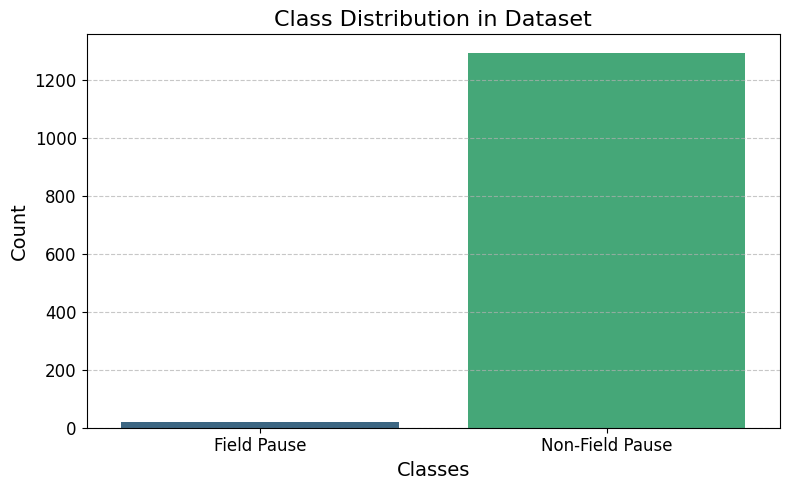

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each class
unique_classes, class_counts = np.unique(y, return_counts=True)

# Create a bar plot for the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=unique_classes, y=class_counts, palette="viridis")

# Set plot labels and title
plt.xlabel("Classes", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Class Distribution in Dataset", fontsize=16)
plt.xticks(ticks=unique_classes, labels=["Field Pause", "Non-Field Pause"], fontsize=12)  # Adjust labels if needed
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
print("Count for Non Filled Pause", class_counts[0])
print("Count for Filled Pause", class_counts[1])

Count for Non Filled Pause 21
Count for Filled Pause 1292


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Example X and y (replace these with your actual data)
X_tensor = torch.tensor(X, dtype=torch.float32)  # Assuming numeric features
y_tensor = torch.tensor(y, dtype=torch.long)    # Labels should be long for CrossEntropyLoss

print(X_tensor.shape)
print(y_tensor.shape)

# Dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

torch.Size([1313, 300, 40])
torch.Size([1313])


In [18]:
# Calculate class weights
from collections import Counter

class_counts = Counter(y)
total_samples = sum(class_counts.values())
class_weights = {label: total_samples / count for label, count in class_counts.items()}
class_weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32)

# Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)  # Map input_dim (40) to hidden_dim (128)
        self.transformer = nn.Transformer(
            d_model=hidden_dim, nhead=4, num_encoder_layers=2, batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)  # Map hidden_dim to number of classes

    def forward(self, x):
        # Input shape: (batch_size, seq_len, input_dim)
        x = self.embedding(x)  # Shape: (batch_size, seq_len, hidden_dim)
        x = self.transformer(x, x)  # Shape: (batch_size, seq_len, hidden_dim)
        x = x.mean(dim=1)  # Pooling: Average across the sequence dimension
        x = self.fc(x)  # Shape: (batch_size, output_dim)
        return x

# Define parameters
input_dim = 40  # Feature size per timestep
hidden_dim = 128  # Hidden size for the transformer
output_dim = 2  # Number of classes (e.g., filled pause vs. non-filled pause)

# Initialize model
model = TransformerModel(input_dim, hidden_dim, output_dim)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10):  # Example: 10 epochs
    model.train()
    epoch_loss = 0

    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader):.4f}")

Epoch 1, Loss: 0.0944
Epoch 2, Loss: 0.0826
Epoch 3, Loss: 0.0843
Epoch 4, Loss: 0.0830
Epoch 5, Loss: 0.0811
Epoch 6, Loss: 0.0849
Epoch 7, Loss: 0.0830
Epoch 8, Loss: 0.0818
Epoch 9, Loss: 0.0834
Epoch 10, Loss: 0.0824


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Get predicted class
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n {cm}")
    
    return accuracy, precision, recall, f1, cm

# Assuming you have a validation or test dataloader `val_dataloader`
evaluate_model(model, val_dataloader)

NameError: name 'val_dataloader' is not defined

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def cross_validate_model(model, X, y, num_folds=5):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold = 1
    accuracies = []

    for train_index, val_index in skf.split(X, y):
        print(f"Training fold {fold}...")
        # Split data into training and validation sets
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Convert data to PyTorch tensors
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val))

        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Initialize model and optimizer
        model = TransformerModel(input_dim=40, hidden_dim=128, output_dim=2)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        # Train the model (you can use the same training loop as before)
        for epoch in range(10):  # Number of epochs
            model.train()
            for inputs, labels in train_dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate the model
        accuracy, _, _, _, _ = evaluate_model(model, val_dataloader)
        accuracies.append(accuracy)
        fold += 1

    print(f"Cross-validation Mean Accuracy: {sum(accuracies) / len(accuracies):.4f}")

# Example usage
cross_validate_model(model, X, y, num_folds=5)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Hyperparameters to tune
param_grid = {
    'hidden_dim': [64, 128, 256],  # Possible hidden dimensions
    'lr': [1e-4, 1e-3, 1e-2],  # Learning rates
}

# Custom scorer using accuracy
def custom_scorer(model, X, y):
    model.eval()
    outputs = model(torch.tensor(X, dtype=torch.float32))
    _, preds = torch.max(outputs, 1)
    return accuracy_score(y, preds)

# Randomized search or grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=make_scorer(custom_scorer))
grid_search.fit(X_train, y_train)  # Replace with your training data
print(f"Best hyperparameters: {grid_search.best_params_}")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Filled", "Filled"], yticklabels=["Non-Filled", "Filled"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have the confusion matrix `cm` from the previous evaluation
plot_confusion_matrix(cm)